In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#let the tensorflow don't take up all the GPU by default
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

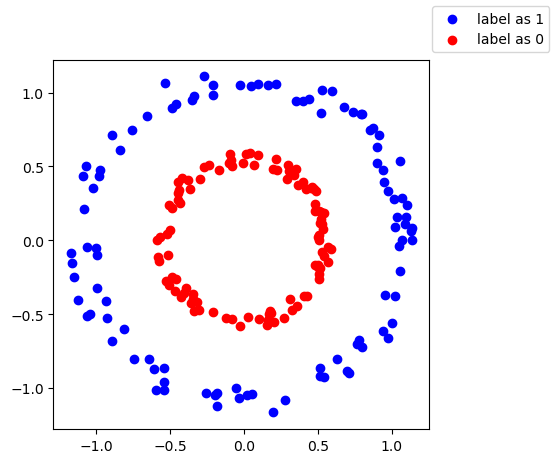

In [7]:
#Create the a dummy data for training
fig, ax = plt.subplots()
ax.set_aspect(aspect='equal')

radius = 1
num_point = 100
np_noise = np.random.rand(num_point)/5+1
np_radian_range = np.linspace(0,2*np.pi,num_point)*np_noise
np_x = np.cos(np_radian_range)*(radius*np_noise)
np_y = np.sin(np_radian_range)*(radius*np_noise)
data_positive = np.stack((np_x,np_y)).T #zip x,y cordinate as model input
label_positive = np.ones(len(data_positive)) #coresponding label as 1

ax.scatter(np_x,np_y,c = 'b')

radius = 0.5
num_point = 100
np_noise = np.random.rand(num_point)/5+1
np_radian_range = np.linspace(0,2*np.pi,num_point)*np_noise
np_x = np.cos(np_radian_range)*(radius*np_noise)
np_y = np.sin(np_radian_range)*(radius*np_noise) 
data_negative = np.stack((np_x,np_y)).T #zip x,y cordinate as model inpout
label_negative = np.zeros(len(data_negative)) #coresponding label as 0

ax.scatter(np_x,np_y, c = 'r')
fig.legend(['label as 1', 'label as 0'])

In [8]:
#prepare training data
train_data = np.concatenate((data_positive, data_negative))
train_label = np.concatenate((label_positive, label_negative))
train_label = train_label[:,np.newaxis] #expend dimension for training
#shuffle the data in the same order
shuffle_order = np.random.permutation(len(train_label))
train_data = train_data[shuffle_order,:]
train_label = train_label[shuffle_order,:]

In [5]:
#create model using keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers
model = Sequential([
    layers.Dense(32,activation = 'relu', input_shape = (2,)),
    layers.Dense(32,activation = 'relu'),
    layers.Dense(1,activation = 'sigmoid')
])
model.build()
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,185
Trainable params: 1,185
Non-trainable params: 0
_________________________________________________________________


In [6]:
def show_process(count, loss_train, loss, data, label, model, range_tuple, interval, save_fig = False):
    xx,yy = np.meshgrid(np.arange(range_tuple[0][0],range_tuple[0][1],interval),np.arange(range_tuple[1][0],range_tuple[1][1],interval))
    z = model(np.c_[xx.ravel(), yy.ravel()], training =False)
    z = z.numpy()
    z = z.reshape(xx.shape)
    fig, ax = plt.subplots()
    fig.set_figheight(5)
    fig.set_figwidth(10)
    time.sleep(pause_t)
    loss_train.append(loss.numpy())
    ax.plot(loss_train)
    ax.set_xlim([0,120])
    ax.set_ylim([0,1])
    ax.set_xlabel('Number of epoch')
    ax.set_ylabel('Loss')
    if save_fig == True:
        plt.savefig('a_'+str(count)+'.jpg')
    plt.show()

    fig, ax = plt.subplots()
    fig.set_figheight(6)
    fig.set_figwidth(8)
    ax.set_aspect(aspect='equal')
    im = ax.contourf(xx,yy,z, vmin = 0, vmax = 1, levels = 100, cmap = plt.cm.RdBu)
    cbar = fig.colorbar(im, ax = ax, ticks=[0,0.25,0.5,0.75,1])
    cbar.ax.set_yticklabels(['0','0.25','0.5','0.75','1'])
    plt.scatter(data[label == 0,0],data[label == 0,1], c = 'r')
    plt.scatter(data[label == 1,0],data[label == 1,1], c = 'b')
    plt.axis('off')
    if save_fig == True:
        plt.savefig(str(count)+'.jpg')
    plt.show()
    

Current loss of this batch:  0.003129163


KeyboardInterrupt: 

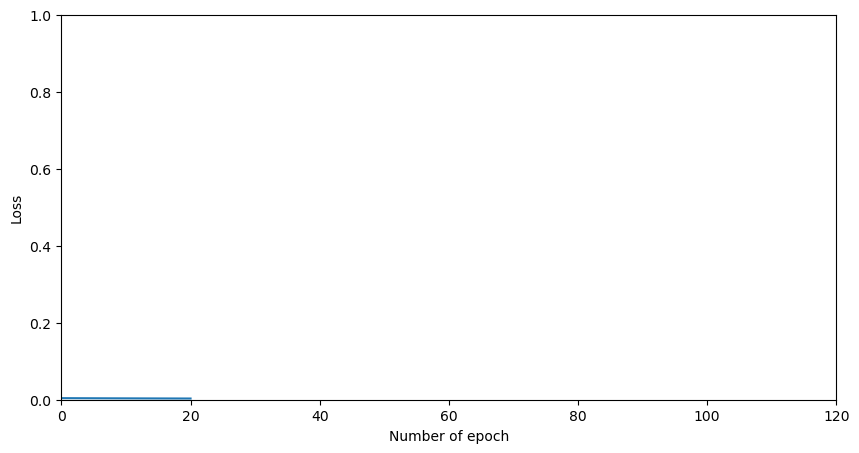

In [307]:
import time
from IPython.display import clear_output
#Customed training loop
pause_t = 0 #slow down the training loop for observation
data_size = len(train_data)
num_epoch = 120 #how many times to go through the training data
loss_func = tf.keras.losses.BinaryCrossentropy(from_logits=False)
learning_rate = 0.1
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
loss_train = [] #use list to collect loss change from each descent step
batch_size = 20 #how many data send for gradient descent in each step
count = 0
for epoch in range(num_epoch):
    for i in range(0, data_size, batch_size): #chop up data in batch for each gradient step
        input = train_data[i:i+batch_size,:]
        target = train_label[i:i+batch_size,:] #ground truth
        with tf.GradientTape() as tape: #use tf.GradientTape to track the gradient
            prediction = model(input, training=True)
            loss = loss_func(y_true = target, y_pred = prediction)
            grads = tape.gradient(loss, model.trainable_variables)
            #one step of graidnet decent
        optimizer.apply_gradients(zip(grads, model.trainable_variables))  
    #==============show the training process==============
    clear_output(wait = True)
    print('Current loss of this batch: ',loss.numpy())
    show_process(count, loss_train, loss, train_data, train_label[:,0],model,([-1.5,1.5],[-1.5,1.5]), 0.01, save_fig=True)
    count+=1
        


In [94]:

def train_model(i):
    xx,yy = np.meshgrid(np.arange(-1.5,1.5,0.01),np.arange(-1.5,1.5,0.01))
    num_steps = int(data_size/batch_size)
    loss_func = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    learning_rate = 0.1
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    label = train_label[:,0]
    input = train_data[i:i+batch_size,:]
    target = train_label[i:i+batch_size,:] #ground truth
    with tf.GradientTape() as tape: #use tf.GradientTape to track the gradient
        prediction = model(input, training=True)
        loss = loss_func(y_true = target, y_pred = prediction)
        grads = tape.gradient(loss, model.trainable_variables)
        #one step of graidnet decent
    optimizer.apply_gradients(zip(grads, model.trainable_variables))  
    #==============show the training process==============
    z = model(np.c_[xx.ravel(), yy.ravel()], training =False)
    z = z.numpy()
    z = z.reshape(xx.shape)
    im = ax.contourf(xx,yy,z, vmin = 0, vmax = 1, levels = 100, cmap = plt.cm.RdBu)
    ax.scatter(train_data[label == 0,0],train_data[label == 0,1], c = 'r')
    ax.scatter(train_data[label == 1,0],train_data[label == 1,1], c = 'b')
    
        

In [116]:
# Enable interactive plot
%matplotlib notebook

![alt text](0.gif "Title")

In [133]:
# Enable interactive plot
from IPython import display
%matplotlib notebook
fig, ax = plt.subplots()
line, = ax.plot([])     # A tuple unpacking to unpack the only plot
ax.set_xlim(0, 2*np.pi)
ax.set_ylim(-1.1, 1.1)
x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x)
def animate(frame_num):
    y = np.sin(x + 2*np.pi * frame_num/100)
    line.set_data((x, y))
    return line
anim = FuncAnimation(fig, animate, frames=100, interval=20)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()      


<IPython.core.display.Javascript object>